<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 57 to 1271
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   week_start_dt     1215 non-null   object 
 1   week_end_dt       1215 non-null   object 
 2   vietnam_season    1215 non-null   int64  
 3   p_color           1215 non-null   object 
 4   price             1215 non-null   float64
 5   total_volume      1215 non-null   float64
 6   brazil            1215 non-null   float64
 7   india             1215 non-null   float64
 8   vietnam           1215 non-null   float64
 9   indonesia         1215 non-null   float64
 10  china             1215 non-null   float64
 11  brazil_season     1215 non-null   bool   
 12  indonesia_season  1215 non-null   bool   
 13  india_season      1215 non-null   bool   
 14  china_season      1215 non-null   bool   
 15  jordan_max_price  1215 non-null   float64
 16  jordan_min_price  1215 non-null   float64

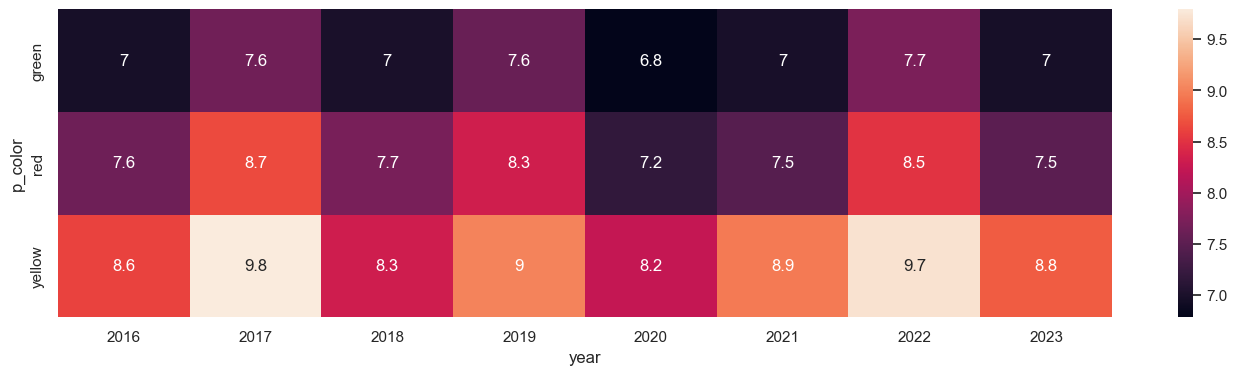

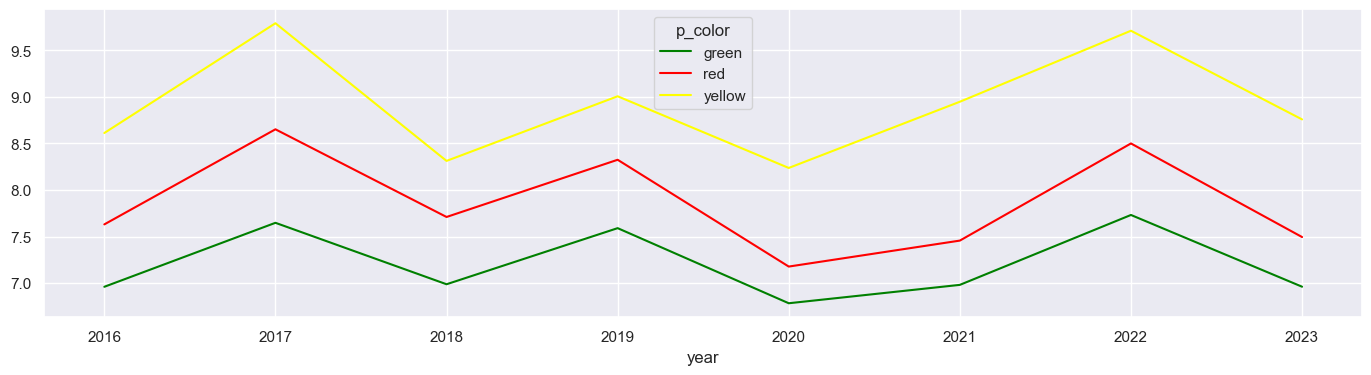

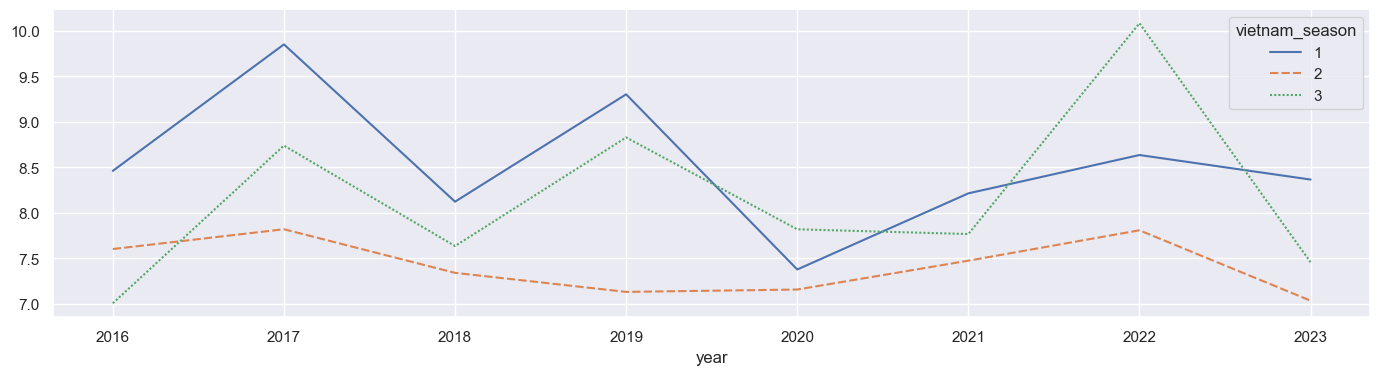

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.501     1.000-27201.805 27200.804
 (0 - 2)      0.082     1.000-27201.222 27201.387
 (0 - 3)   -221.504     1.000-27422.808 26979.800
 (0 - 4)    -86.517     1.000-27287.821 27114.787
 (0 - 5)  -8479.636     0.993-35680.941 18721.668
 (0 - 6) -245295.023     0.000-272496.327-218093.719
 (0 - 7) -28736.095     0.029-55937.400 -1534.791
 (0 - 8) -154940.070     0.000-182141.374-127738.766
 (0 - 9) -1806521.517     0.000-1833722.821-1779320.212
 (1 - 0)      0.501     1.000-27200.804 27201.805
 (1 - 2)      0.583     1.000-27200.722 27201.887
 (1 - 3)   -221.003     1.000-27422.308 26980.301
 (1 - 4)    -86.016     1.000-27287.321 27115.288
 (1 - 5)  -8479.136     0.993-35680.440 18722.169
 (1 - 6) -245294.522     0.000-272495.827-218093.218
 (1 - 7) -28735.595     0.029-55936.899 -1534.290
 (1 - 8) -154939.569     0.000-182140.874-127738.265
 (1 - 9) -1806

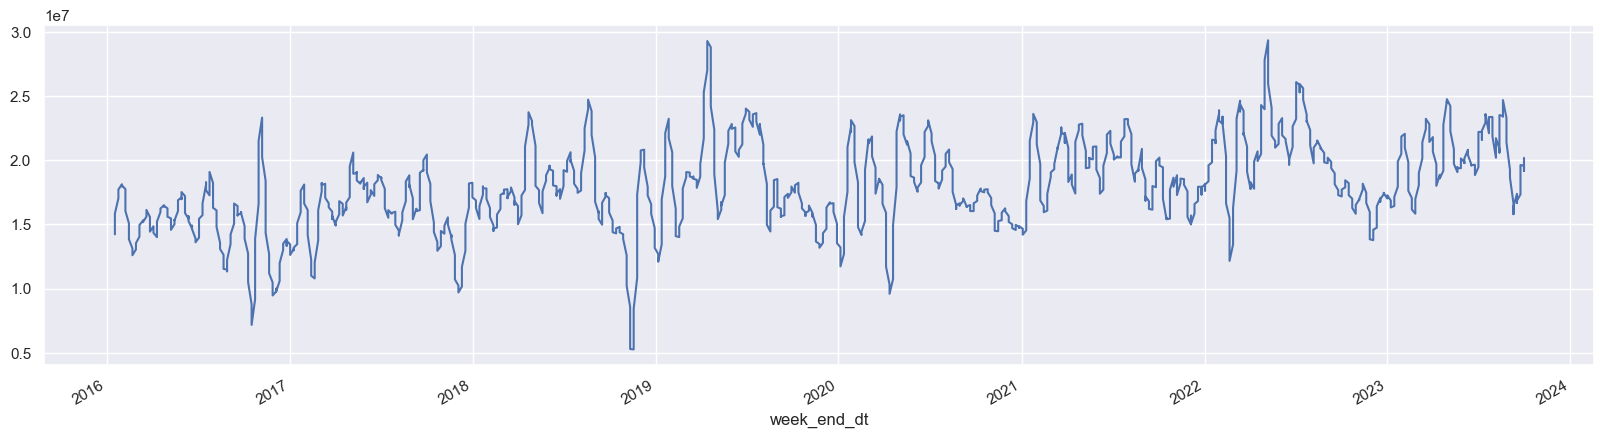

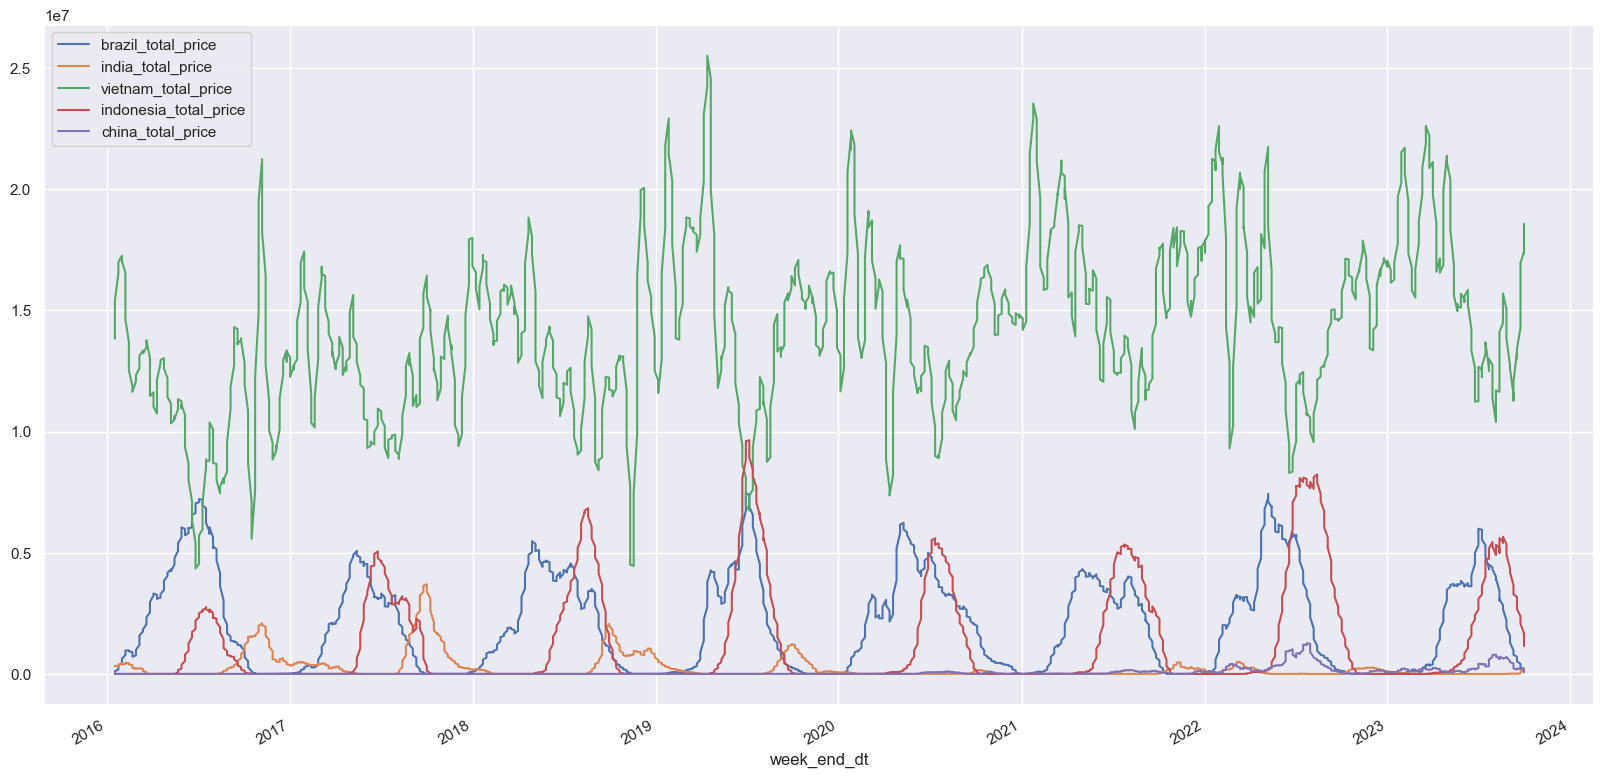

(405, 32) (405, 32) (405, 32)


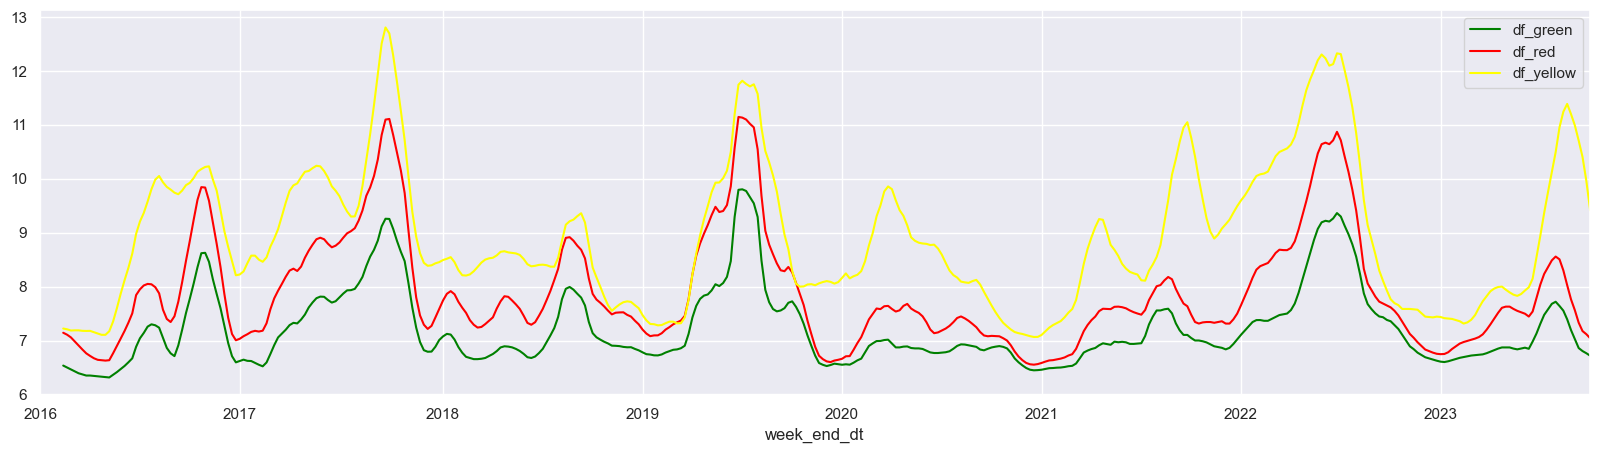

(409, 496) (409, 496) (409, 496)
(402, 478) (402, 478) (402, 478)
(402, 478) (402, 478) (402, 478)


In [1]:
%run C:\Users\Omar\DataspellProjects\Intern_Final_Project\notebooks\Data_Cleaning\Features_Selection.ipynb

### *cross validation*

*We will keep the last 16 rows of the dataset and do a Rolling Moving Origin of step size of 4*


*lets explain this visually*

In [2]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [3]:
from sklearn.model_selection import TimeSeriesSplit


In [4]:
test_data_red=df_red[-16:]
#####
X = test_data_red.drop("price",axis=1)
y = test_data_red["price"]
date=test_data_red.reset_index()["week_end_dt"]
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[4 5 6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[ 8  9 10 11]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14 15]


The above code out come expresess how the cross validation works ,
1st fold : we consider the 4 intial points as train data and the next 4 points as test data
2ns fold : the test points from the prevuoys fold we be appened to the new train points asnd new points ahead are test points
3rd fold : works as metioned above

The below chart is ease the process:


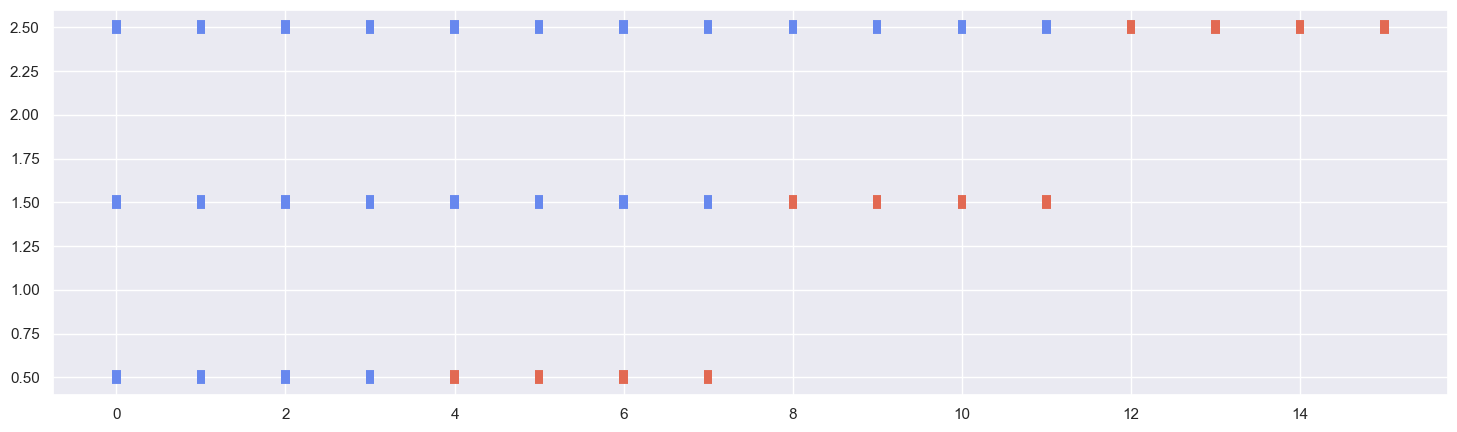

In [5]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, n_splits, X, y):
    fig, ax = plt.subplots(1, 1, figsize = (18, 5))
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
plot_cv_indices(cv=tscv,n_splits=3,X=X,y=y)

---
importing needed libraries

In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_tree,plot_importance,XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm.sklearn import LGBMRegressor
import warnings                                  
warnings.filterwarnings('ignore')

In [7]:
def data_scale():   
     scaler = StandardScaler()
     for col in df_red:
           if col not in ["price"]:
                  df_red[col]=scaler.fit_transform(df_red[[col]])

     for col in df_green:
           if col not in ["price"]:
                  df_green[col]=scaler.fit_transform(df_green[[col]])

     for col in df_yellow:
           if col not in ["price"]:
                  df_yellow[col]=scaler.fit_transform(df_yellow[[col]])             


data_scale()

In [8]:
def train_test(data):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    mae_scores = []
    y_pred_results=[]

    models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
    models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]


    test_data=data[-20:]
    time_series_data = test_data.values

    for model in models:
              for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred = model.predict(X_test)
                                  y_pred_results.append(y_pred)
                                  mae = np.mean(mean_absolute_error(y_test, y_pred))
                                  mae_scores.append(mae)    
                                  outcome=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[20:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[24:28]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[28:32]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[32:36]).stack().reset_index(drop=True))],axis=1)
                                  new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                                  new_date_index=pd.DataFrame({"date":new_date_index})
                                  outcome.columns=models_names
                                  outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")

                                  outcome_mae=pd.concat([pd.DataFrame(pd.DataFrame(mae_scores[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[20:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[24:28]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[28:32]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[32:36]).stack().reset_index(drop=True))],axis=1)
                                  outcome_mae.columns=models_names
                                  
                                  




    return outcome_all,outcome_mae        

In [9]:

df_red_outcomes=train_test(data=df_red)
df_green_outcomes=train_test(data=df_green)
df_yellow_outcomes=train_test(data=df_yellow)

Learning rate set to 0.017112
0:	learn: 0.4358590	total: 138ms	remaining: 2m 17s
1:	learn: 0.4337821	total: 139ms	remaining: 1m 9s
2:	learn: 0.4315710	total: 139ms	remaining: 46.3s
3:	learn: 0.4293726	total: 140ms	remaining: 34.9s
4:	learn: 0.4275758	total: 141ms	remaining: 28.1s
5:	learn: 0.4253988	total: 142ms	remaining: 23.6s
6:	learn: 0.4232342	total: 143ms	remaining: 20.3s
7:	learn: 0.4214639	total: 144ms	remaining: 17.9s
8:	learn: 0.4197023	total: 145ms	remaining: 16s
9:	learn: 0.4179494	total: 146ms	remaining: 14.5s
10:	learn: 0.4161614	total: 147ms	remaining: 13.2s
11:	learn: 0.4144506	total: 148ms	remaining: 12.2s
12:	learn: 0.4126776	total: 149ms	remaining: 11.3s
13:	learn: 0.4109122	total: 151ms	remaining: 10.6s
14:	learn: 0.4091543	total: 152ms	remaining: 9.97s
15:	learn: 0.4074482	total: 153ms	remaining: 9.39s
16:	learn: 0.4057051	total: 154ms	remaining: 8.9s
17:	learn: 0.4036410	total: 155ms	remaining: 8.44s
18:	learn: 0.4019142	total: 156ms	remaining: 8.05s
19:	learn: 0.

In [10]:
pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,6,5,2,4,8,1,0,3,7
index,AdaBoostRegressor_boo,XGBRFRegressor_boo,SVR(),XGBRegressor_boo,CatBoostRegressor_boo,RandomForestRegressor,DecisionTreeRegressor,LinearRegression,LGBMRegressor_boo
score,2.242544,2.263427,2.390601,2.397107,2.432192,2.449592,2.579155,2.633458,2.690026


In [11]:
pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,6,4,5,0,2,1,8,7,3
index,AdaBoostRegressor_boo,XGBRegressor_boo,XGBRFRegressor_boo,DecisionTreeRegressor,SVR(),RandomForestRegressor,CatBoostRegressor_boo,LGBMRegressor_boo,LinearRegression
score,1.999644,2.023283,2.027003,2.068038,2.072525,2.080522,2.092057,2.287597,2.327233


In [12]:
pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,3,0,6,2,1,5,4,8,7
index,LinearRegression,DecisionTreeRegressor,AdaBoostRegressor_boo,SVR(),RandomForestRegressor,XGBRFRegressor_boo,XGBRegressor_boo,CatBoostRegressor_boo,LGBMRegressor_boo
score,2.891594,2.940008,2.955728,3.09313,3.16896,3.169931,3.181098,3.217818,3.608196


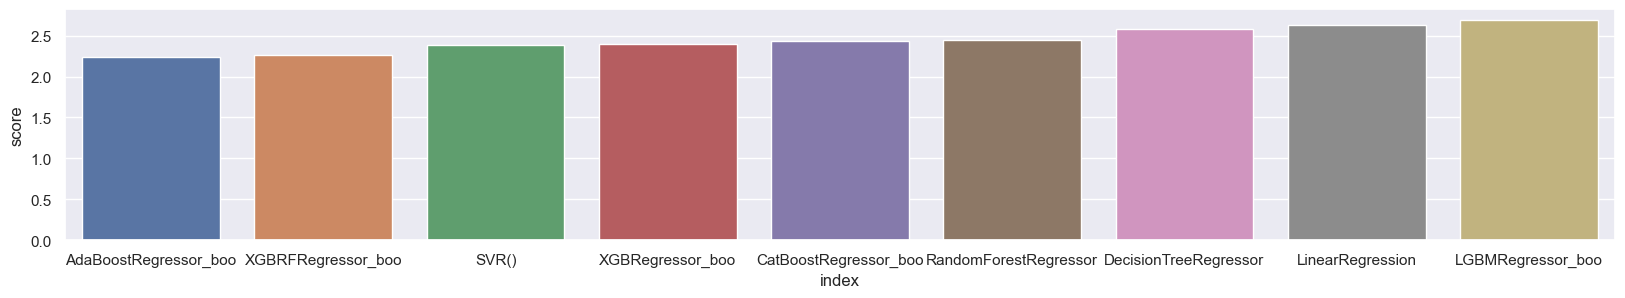

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

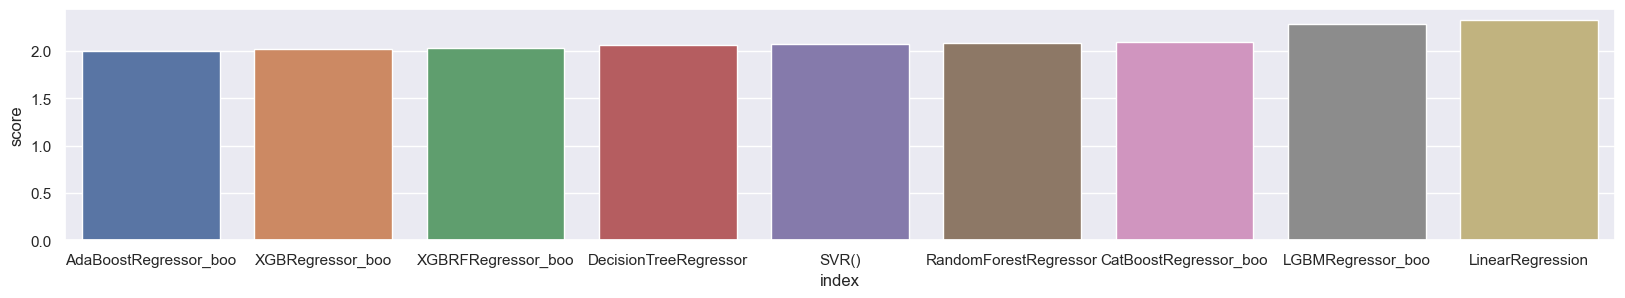

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

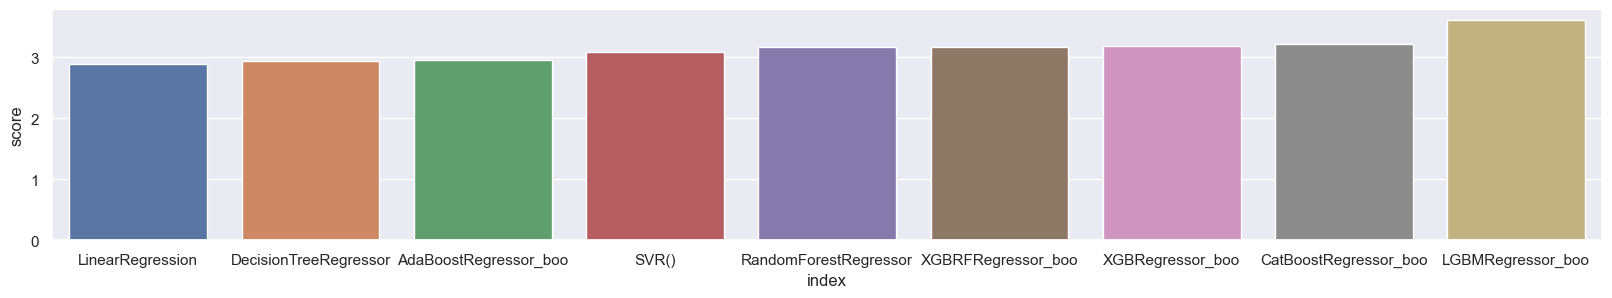

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

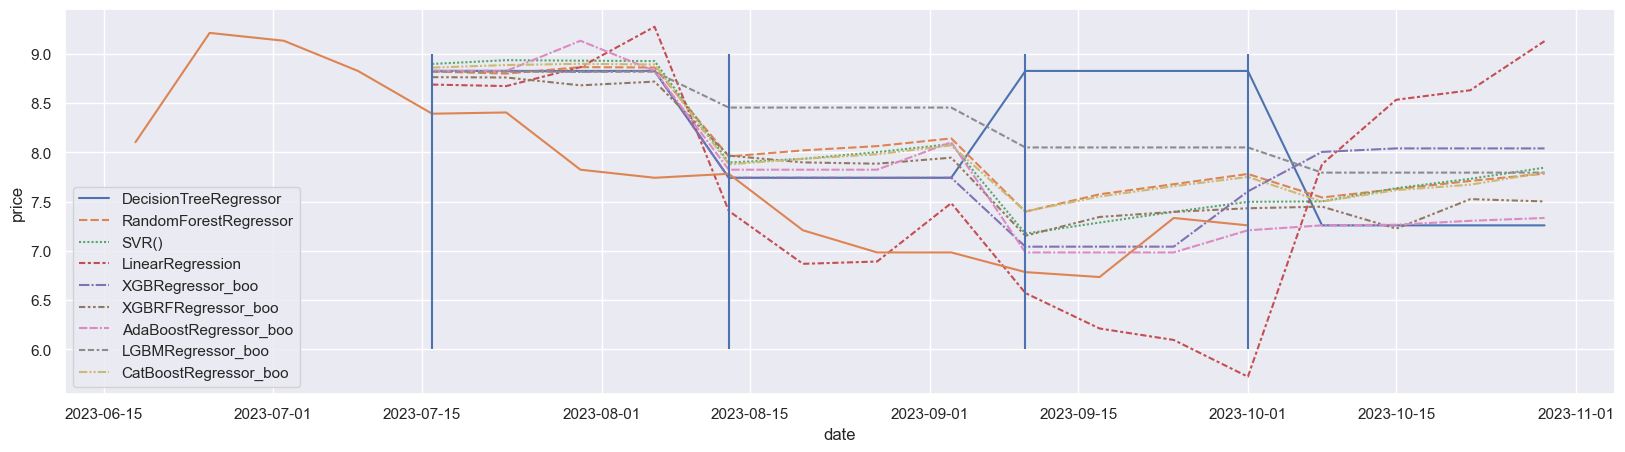

In [16]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 9
sns.lineplot(df_red_outcomes[0]);
sns.lineplot(df_red[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

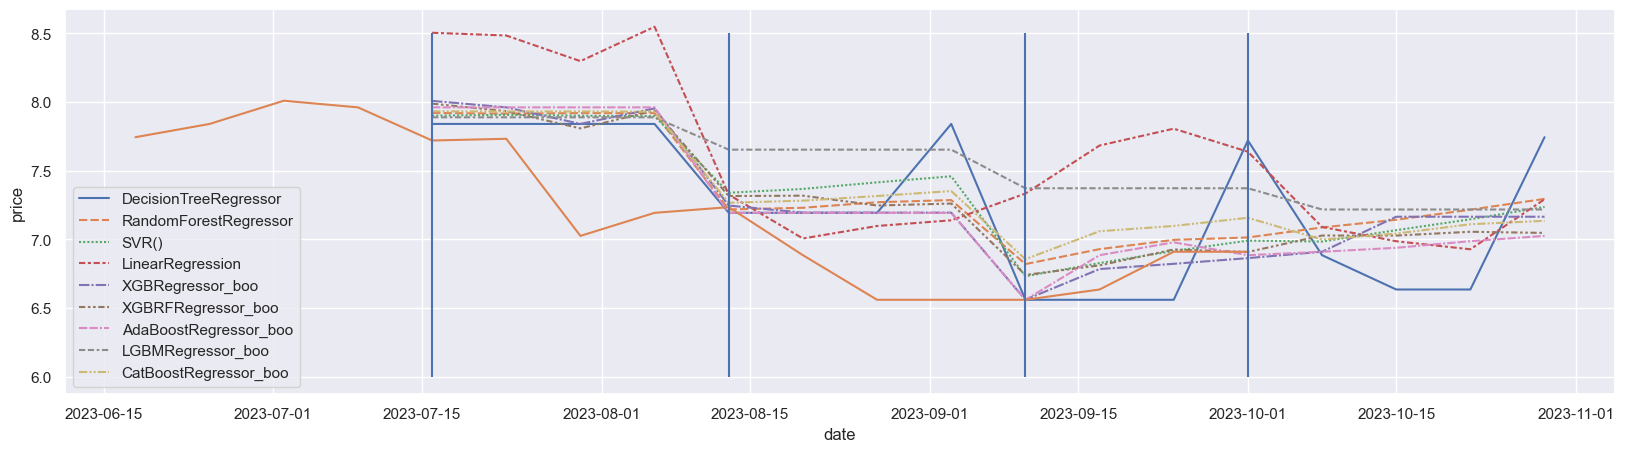

In [17]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 8.5
sns.lineplot(df_green_outcomes[0]);
sns.lineplot(df_green[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

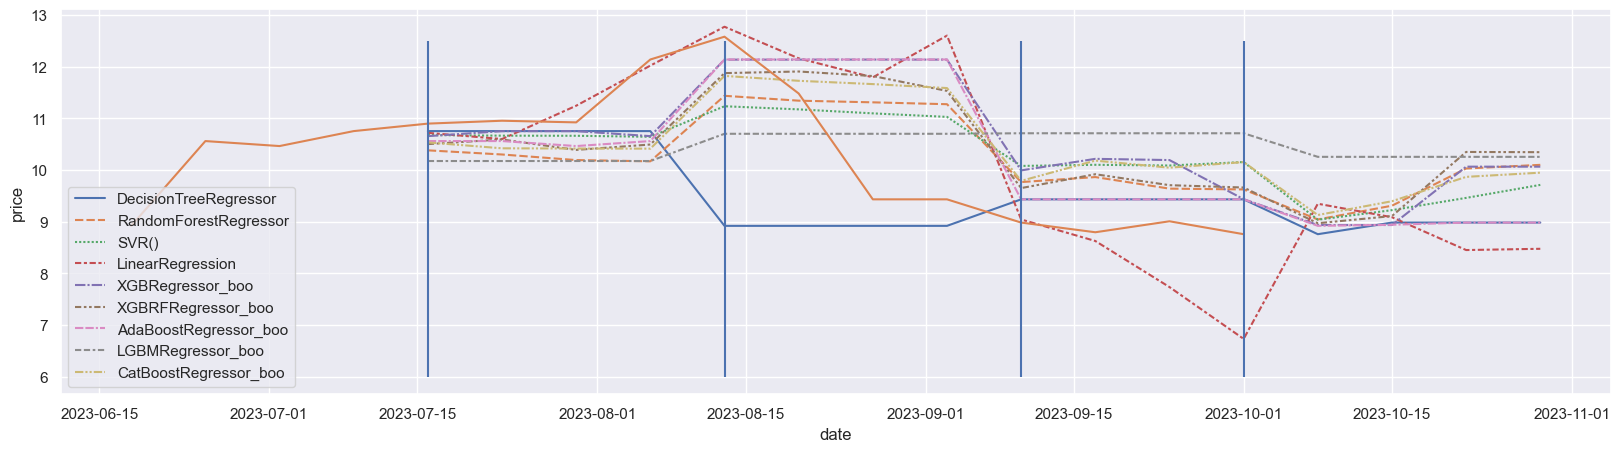

In [18]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6 
y_max = 12.5
sns.lineplot(df_yellow_outcomes[0]);
sns.lineplot(df_yellow[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

---

## *Hyperparamers tunning*

In [19]:
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp

In [20]:
space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : hp.uniform("gamma", 0, 1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10)),
    'seed' : 44 }

In [21]:
def objective(space):
   test_data=df_red[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = XGBRegressor(max_depth=int(space['max_depth']),
                                                           eta=float(space['eta']),
                                                           gamma=float(space['gamma']),
                                                           colsample_bytree=float(space['colsample_bytree']),
                                                           colsample_bynode=float(space['colsample_bynode']),
                                                           colsample_bylevel=float(space['colsample_bylevel']),
                                                           n_estimators=int(space['n_estimators']),
                                                           seed=int(space['seed']))    
                                                             
                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae= np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }
   
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)   

100%|██████████| 100/100 [00:16<00:00,  6.12trial/s, best loss: 0.5283946169982912]
{'colsample_bylevel': 0.804722512250741, 'colsample_bynode': 0.6674860922872073, 'colsample_bytree': 0.6888493581346306, 'eta': 0.9991568986208634, 'gamma': 0.24925116333926212, 'max_depth': 7, 'n_estimators': 73}


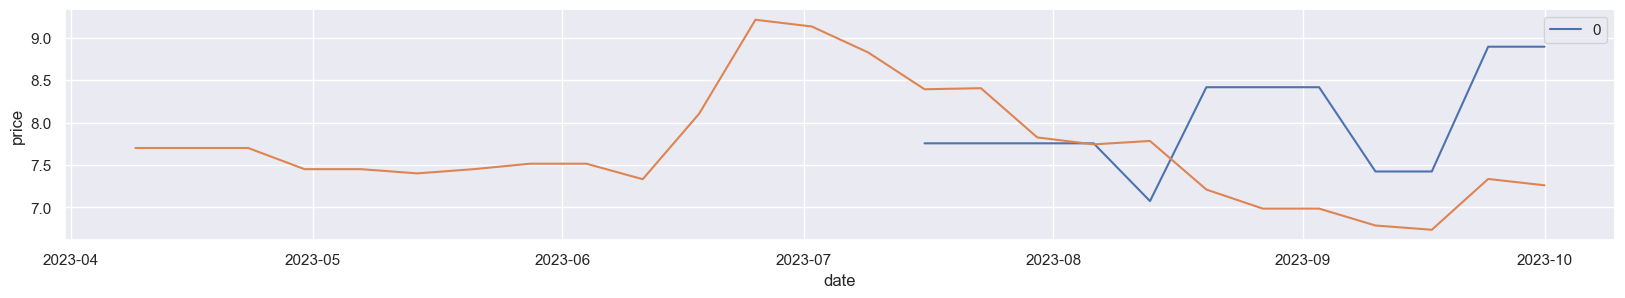

In [22]:
y_pred_results=[]
test_data=df_red[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=XGBRegressor(max_depth=int(best['max_depth']),
                                                           eta=float(best['eta']),
                                                           gamma=float(best['gamma']),
                                                           colsample_bytree=float(best['colsample_bytree']),
                                                           colsample_bynode=float(best['colsample_bynode']),
                                                           colsample_bylevel=float(best['colsample_bylevel']),
                                                           n_estimators=int(best['n_estimators'])).fit(X_train,y_train)
                 
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results.append(y_pred)
                outcome=pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")
                                

fig, ax = plt.subplots(figsize = (20,3));
sns.lineplot(outcome_all);
sns.lineplot(df_red['price'][-30:-4]);                                  

In [23]:
import statsmodels.api as sm

In [83]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [147]:
model = sm.tsa.statespace.SARIMAX(df_red['price'],
                                  order = (3,1,3),
                                  seasonal_order=(3, 1, 3, 52),
                                  enforce_stationarity=True,
                                  enforce_invertibility=False)
result = model.fit()
print(result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  398
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 52)   Log Likelihood                -197.360
Date:                            Sat, 21 Oct 2023   AIC                            420.721
Time:                                    02:43:11   BIC                            470.687
Sample:                                02-21-2016   HQIC                           440.620
                                     - 10-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8330      2.695      0.309      0.757      -4.449       6.115
ar.L2         -0.7000      1.071   

7.8951277748115585


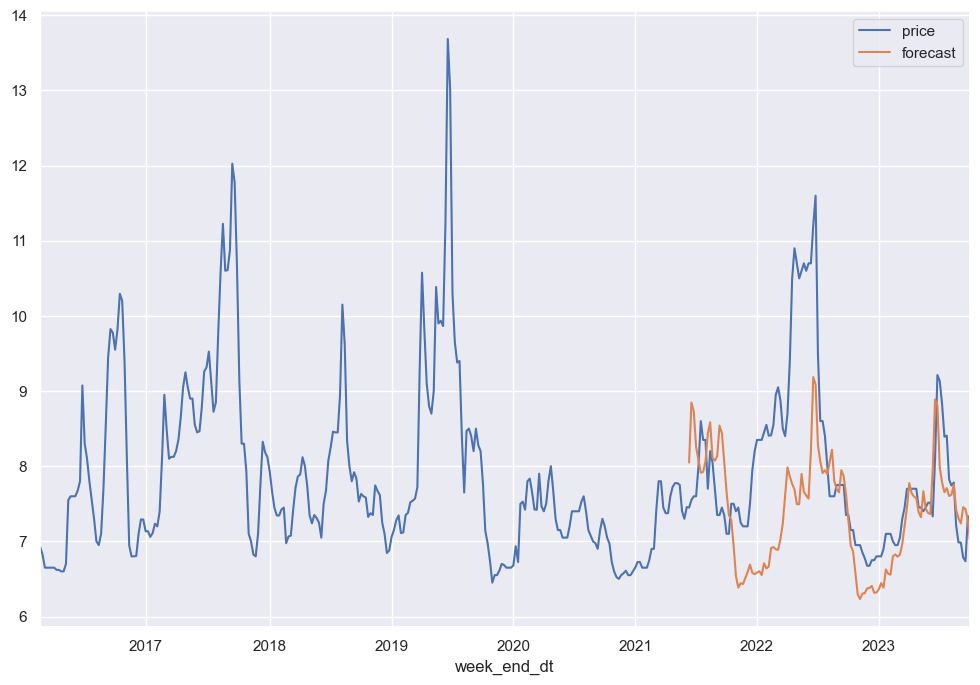

In [153]:
df_red['forecast']=result.predict(start='2021-06-13',dynamic=True)

df_red[['price','forecast']].plot(figsize=(12,8))
print(mae)

plt.show()

In [26]:
df.tail()

,price,total_volume,brazil,india,vietnam,indonesia,china,brazil_season,indonesia_season,india_season,...,india_volume_percetntage,vietnam_volume_percetntage,indonesia_volume_percetntage,china_volume_percetntage,total_volume_total_price,brazil_total_price,india_total_price,vietnam_total_price,indonesia_total_price,china_total_price
week_end_dt,,,,,,,,,,,,,,,,,,,,,
2023-09-24,7.334644,2761128.0,8695.6,29937.0,2530027.4,180220.8,12246.9,0,0,1,...,0.01,0.92,0.07,0.0,20251891.75,63779.13,219577.25,18556851.05,1321855.46,89826.66
2023-09-24,9.008137,2761128.0,8695.6,29937.0,2530027.4,180220.8,12246.9,0,0,1,...,0.01,0.92,0.07,0.0,24872618.75,78331.15,269676.59,22790832.93,1623453.62,110321.75
2023-10-01,7.259712,2665343.9,167.8,45376.1,2521054.0,78334.2,8618.2,0,0,1,...,0.02,0.95,0.03,0.0,19349628.56,1218.18,329417.41,18302125.47,568683.72,62565.65
2023-10-01,6.910027,2665343.9,167.8,45376.1,2521054.0,78334.2,8618.2,0,0,1,...,0.02,0.95,0.03,0.0,18417597.78,1159.50,313550.07,17420550.70,541291.42,59551.99
2023-10-01,8.758362,2665343.9,167.8,45376.1,2521054.0,78334.2,8618.2,0,0,1,...,0.02,0.95,0.03,0.0,23344046.20,1469.65,397420.30,22080303.05,686079.26,75481.31


In [27]:
df

,price,total_volume,brazil,india,vietnam,indonesia,china,brazil_season,indonesia_season,india_season,...,india_volume_percetntage,vietnam_volume_percetntage,indonesia_volume_percetntage,china_volume_percetntage,total_volume_total_price,brazil_total_price,india_total_price,vietnam_total_price,indonesia_total_price,china_total_price
week_end_dt,,,,,,,,,,,,,,,,,,,,,
2016-01-03,6.599075,1596040.2,10793.5,65658.1,1519588.5,0.0,0.0,0,0,0,...,0.04,0.95,0.00,0.0,10532388.98,71227.12,433282.73,10027878.48,0.00,0.00
2016-01-03,7.175335,1596040.2,10793.5,65658.1,1519588.5,0.0,0.0,0,0,0,...,0.04,0.95,0.00,0.0,11452123.11,77446.98,471118.86,10903556.55,0.00,0.00
2016-01-03,7.300575,1596040.2,10793.5,65658.1,1519588.5,0.0,0.0,0,0,0,...,0.04,0.95,0.00,0.0,11652011.18,78798.76,479341.88,11093869.81,0.00,0.00
2016-01-10,7.379675,2295578.0,5677.8,15274.4,2274625.7,0.0,0.0,0,0,0,...,0.01,0.99,0.00,0.0,16940619.58,41900.32,112720.11,16785998.41,0.00,0.00
2016-01-10,7.175335,2295578.0,5677.8,15274.4,2274625.7,0.0,0.0,0,0,0,...,0.01,0.99,0.00,0.0,16471541.17,40740.12,109598.94,16321201.40,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24,7.334644,2761128.0,8695.6,29937.0,2530027.4,180220.8,12246.9,0,0,1,...,0.01,0.92,0.07,0.0,20251891.75,63779.13,219577.25,18556851.05,1321855.46,89826.66
2023-09-24,9.008137,2761128.0,8695.6,29937.0,2530027.4,180220.8,12246.9,0,0,1,...,0.01,0.92,0.07,0.0,24872618.75,78331.15,269676.59,22790832.93,1623453.62,110321.75
2023-10-01,7.259712,2665343.9,167.8,45376.1,2521054.0,78334.2,8618.2,0,0,1,...,0.02,0.95,0.03,0.0,19349628.56,1218.18,329417.41,18302125.47,568683.72,62565.65


In [73]:
from statsmodels.tsa.stattools import adfuller


In [74]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [76]:
adf_test(df_red['price'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.789916
p-value                          0.000057
#Lags Used                       5.000000
Number of Observations Used    392.000000
Critical Value (1%)             -3.447142
Critical Value (5%)             -2.868941
Critical Value (10%)            -2.570713
dtype: float64


In [31]:
df_red.drop(df_red.tail(4).index,inplace=True)

In [32]:
df_red.tail()

,price,total_volume,brazil,india,vietnam,indonesia,china,brazil_season,indonesia_season,china_season,...,china_total_price_shift_4_Rolling_7,china_total_price_shift_5_Rolling_6,china_total_price_shift_5_Rolling_7,china_total_price_shift_6_Rolling_4,china_total_price_shift_6_Rolling_6,china_total_price_shift_6_Rolling_7,china_total_price_shift_7_Rolling_2,china_total_price_shift_7_Rolling_4,china_total_price_shift_7_Rolling_6,china_total_price_shift_7_Rolling_7
week_end_dt,,,,,,,,,,,,,,,,,,,,,
2023-09-03,6.984959,0.004390,-0.533095,-0.423695,-0.310518,1.338680,0.315604,-0.878023,-0.590757,1.383128,...,2.629186,2.590181,2.328317,2.748500,2.109108,2.038030,0.806964,1.598125,1.422092,1.277964
2023-09-10,6.785139,-0.134160,-0.684577,-0.500501,-0.201422,0.909817,0.675725,-0.878023,-0.590757,1.383128,...,3.119236,2.902006,2.637038,2.603443,2.599965,2.342570,3.191416,2.761583,2.125732,2.055982
2023-09-17,6.735184,0.350920,-0.839484,-0.500501,0.361827,0.642649,1.565446,-0.878023,-0.590757,1.383128,...,2.743259,2.920287,3.127805,3.142777,2.912432,2.652445,4.179869,2.616100,2.619025,2.362236
2023-09-24,7.334644,1.065356,-0.992813,0.034137,1.253018,0.098557,0.167315,-0.878023,-0.590757,1.383128,...,3.321941,3.091821,2.751278,3.830630,2.930751,3.145049,2.828234,3.157018,2.933043,2.673855
2023-10-01,7.259712,0.866505,-1.028474,0.309860,1.237440,-0.319672,-0.002154,-0.878023,-0.590757,-0.722999,...,3.165439,3.607693,3.330807,2.835348,3.102638,2.767113,3.157011,3.846890,2.951453,3.169231


In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


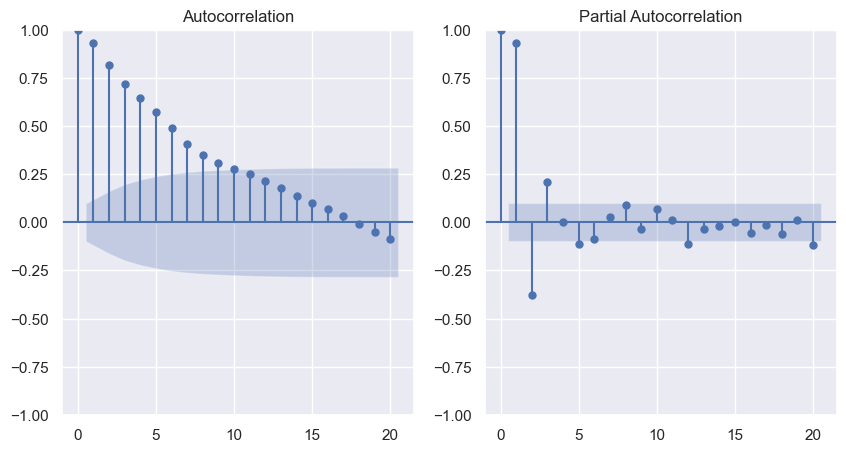

In [81]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_acf(df_red['price'], ax=plt.gca(), lags=20)

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(df_red['price'], ax=plt.gca(), lags=20)

plt.show()